GROUP NUMBER 208
Group Members:

Bhavuk Saraswat
Varun Sapra
Aditya Harsh
Varun Sharma
Yashvi Pancholi
Arpita Nigam
Jatin Agarwal

INTRODUCTION
In our group project we focused on developing a plant disease prediction model, we've meticulously examined three prominent deep learning architectures: VGG16, Inception3, and AlexNet. Each model offers distinct advantages and characteristics that can contribute to the accuracy and efficiency of our predictive system. In this project we will delve into the intricacies of Inception3, highlighting its architecture, strengths, and how it can be optimized for our specific application in plant disease prediction.
```


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

In [ ]:
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset


Dataset URL: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset
License(s): copyright-authors
100% 2.69G/2.70G [00:20<00:00, 235MB/s]
100% 2.70G/2.70G [00:20<00:00, 139MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/new-plant-diseases-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()


In [ ]:
import os
import cv2 as cv
import glob as gb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import Model, layers, Sequential, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow import keras
from tensorflow.keras import callbacks, layers, Model

In [ ]:
train_dir='/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
valid_dir='/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'
test_dir='/content/test/test'

In [ ]:
Size=224
X_test=[]
y_test=[]

Data augmentation

In [ ]:
import tensorflow as tf
train_generator=tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    rescale=1/255.0,
).flow_from_directory(train_dir,batch_size=16,target_size=(Size,Size),subset="training",shuffle=True)

Found 70295 images belonging to 38 classes.


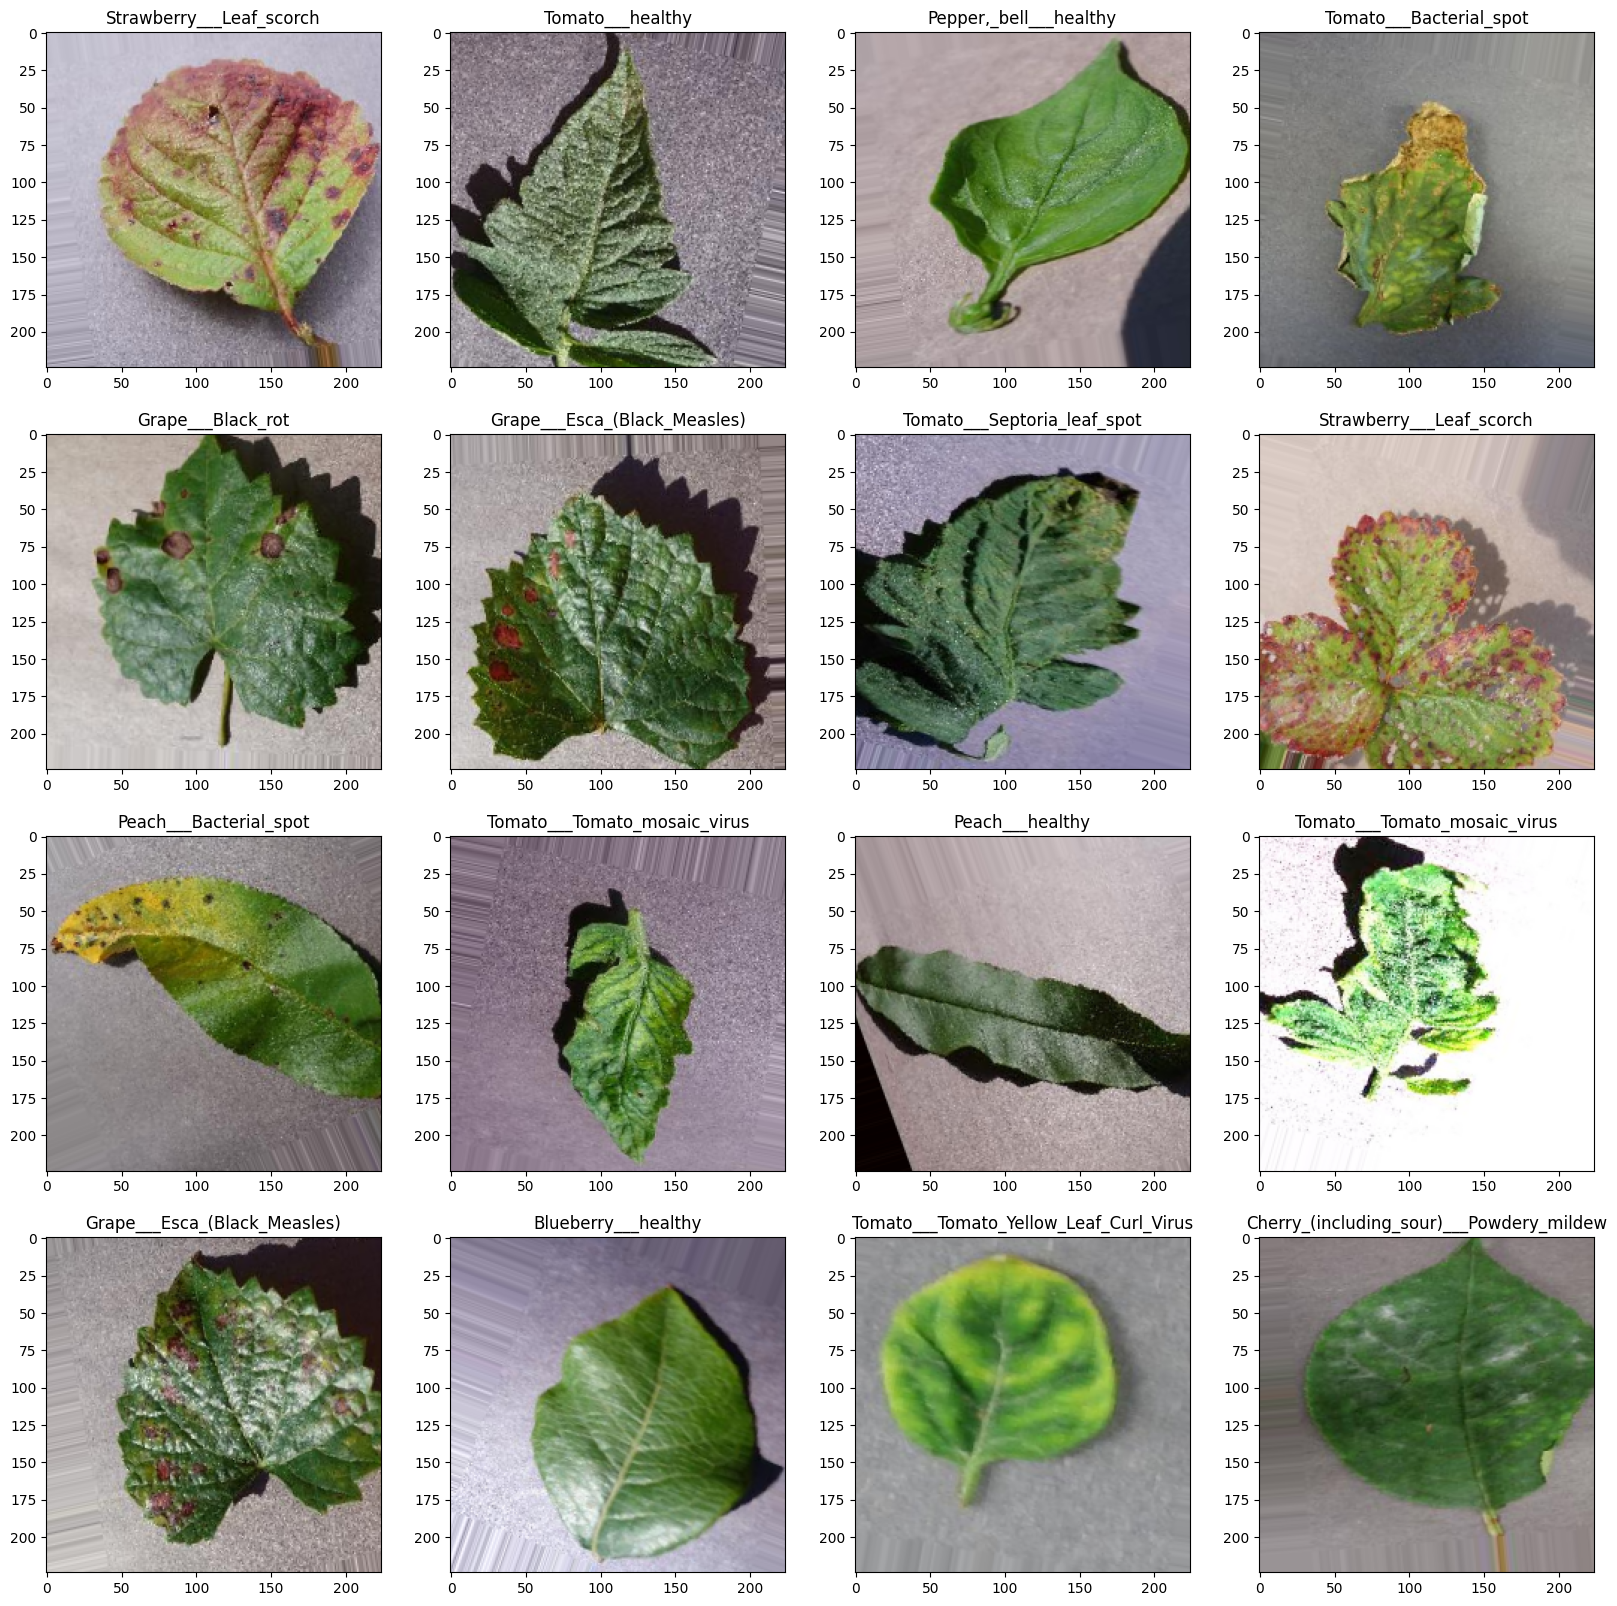

In [ ]:
classes=list(train_generator.class_indices.keys())
plt.figure(figsize=(20,20))
for X_batch, y_batch in train_generator:

    for i in range(0,16):
        plt.subplot(4,4,i+1)
        plt.imshow(X_batch[i])
        plt.title(classes[np.where(y_batch[i]==1)[0][0]])
    # show the plot
    plt.show()
    break

In [ ]:
print(classes)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

In [ ]:
valid_generator=tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255.0,
).flow_from_directory(valid_dir,batch_size=16,target_size=(Size,Size),shuffle=False)

Found 17572 images belonging to 38 classes.


In [ ]:
X_test=[]
for folder in os.listdir(test_dir):
    files=gb.glob(test_dir+'/*.JPG')
    for file in files :
        img=cv.imread(file)
        X_test.append(cv.resize(img,(Size,Size)))

In [ ]:
X_test=np.array(X_test)
print(X_test.shape)

(1089, 224, 224, 3)


In [ ]:
X_test=X_test/255.0

In [ ]:
import keras
from keras.layers import Flatten , Dense , Dropout , BatchNormalization , MaxPooling2D ,Conv2D
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau ,ModelCheckpoint

In [ ]:
EarlyStop=EarlyStopping(patience=10,restore_best_weights=True)
Reduce_LR=ReduceLROnPlateau(monitor='val_accuracy',verbose=2,factor=0.5,min_lr=0.00001)
model_check=ModelCheckpoint('model.hdf5',monitor='val_loss',verbose=1,save_best_only=True)
callback=[EarlyStop , Reduce_LR,model_check]

INCEPTION MODEL

In [ ]:
inception_model = InceptionV3(input_shape= (Size, Size, 3),
                                include_top = False,
                                weights = "imagenet")



for layer in inception_model.layers:
    layer.trainable = False


# Taking output from 'mixed8' layer
last_layer = inception_model.get_layer('mixed9')
print('Last Layer Output Shape:', last_layer.output_shape)
last_output = last_layer.output


x = layers.Flatten()(last_output)

x = layers.Dense(2048, activation='relu')(x)

x = layers.Dense(1024, activation='relu')(x)

x = layers.Dropout(0.2)(x)

x = layers.Dense(38, activation='softmax')(x)

inception3 = Model(inception_model.input, x)

87910968/87910968 [==============================] - 1s 0us/step
Last Layer Output Shape: (None, 5, 5, 2048)


In [ ]:
inception3.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history=inception3.fit(train_generator,validation_data=valid_generator,epochs=100,batch_size=32,
                  steps_per_epoch=len(train_generator)//16,validation_steps=len(valid_generator)//16,
                  callbacks=callback, verbose=1)

Epoch 1/100
274/274 [==============================] - ETA: 0s - loss: 0.7411 - accuracy: 0.7767
Epoch 1: val_loss improved from 1.01424 to 0.32842, saving model to model.hdf5
274/274 [==============================] - 93s 338ms/step - loss: 0.7411 - accuracy: 0.7767 - val_loss: 0.3284 - val_accuracy: 0.9136 - lr: 0.0010
Epoch 2/100
274/274 [==============================] - ETA: 0s - loss: 0.5808 - accuracy: 0.8216
Epoch 2: val_loss did not improve from 0.32842
274/274 [==============================] - 78s 283ms/step - loss: 0.5808 - accuracy: 0.8216 - val_loss: 0.8492 - val_accuracy: 0.7656 - lr: 0.0010
Epoch 3/100
274/274 [==============================] - ETA: 0s - loss: 0.5369 - accuracy: 0.8422
Epoch 3: val_loss did not improve from 0.32842
274/274 [==============================] - 71s 260ms/step - loss: 0.5369 - accuracy: 0.8422 - val_loss: 0.5961 - val_accuracy: 0.8281 - lr: 0.0010
Epoch 4/100
274/274 [==============================] - ETA: 0s - loss: 0.4841 - accuracy: 0.854

In [ ]:
ModelLoss, ModelAccuracy = inception3.evaluate(valid_generator)
print('Test Loss is {}'.format(ModelLoss))
print('Test Accuracy is {}'.format(ModelAccuracy))

1099/1099 [==============================] - 47s 43ms/step - loss: 0.2591 - accuracy: 0.9254
Test Loss is 0.2590530812740326
Test Accuracy is 0.925449550151825


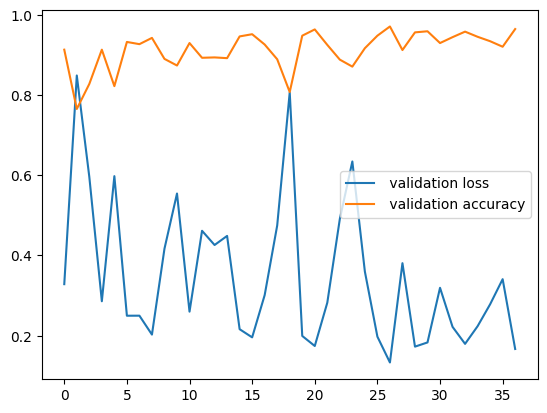

In [ ]:
plt.plot(history.history['val_loss'],label=' validation loss')
plt.plot(history.history['val_accuracy'],label=' validation accuracy')
plt.legend()

In [ ]:
inceptionv3_accuracy = history.history['val_accuracy'][len(history.history['val_accuracy'])-1]

VGG

In [ ]:
vgg16 = tf.keras.applications.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(Size,Size,3)
)
vgg16.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
inputs = keras.Input(shape=(Size,Size,3))

# Get the layer
x = vgg16(inputs, training = False)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(4096, activation="relu")(x)
x = tf.keras.layers.Dense(4096, activation="relu")(x)

x = tf.keras.layers.Dense(38, activation="softmax")(x)

VGG16 = Model(inputs=inputs, outputs=x)

In [ ]:
VGG16.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history=VGG16.fit(train_generator,validation_data=valid_generator,epochs=100,batch_size=32,
                  steps_per_epoch=len(train_generator)//16,validation_steps=len(valid_generator)//16,
                  callbacks=callback, verbose=1)

Epoch 1/100
274/274 [==============================] - ETA: 0s - loss: 2.6939 - accuracy: 0.3987
Epoch 1: val_loss did not improve from 0.13300
274/274 [==============================] - 76s 256ms/step - loss: 2.6939 - accuracy: 0.3987 - val_loss: 0.9470 - val_accuracy: 0.6461 - lr: 0.0010
Epoch 2/100
274/274 [==============================] - ETA: 0s - loss: 1.0788 - accuracy: 0.6510
Epoch 2: val_loss did not improve from 0.13300
274/274 [==============================] - 67s 243ms/step - loss: 1.0788 - accuracy: 0.6510 - val_loss: 1.7536 - val_accuracy: 0.4550 - lr: 0.0010
Epoch 3/100
274/274 [==============================] - ETA: 0s - loss: 0.9001 - accuracy: 0.7051
Epoch 3: val_loss did not improve from 0.13300
274/274 [==============================] - 69s 251ms/step - loss: 0.9001 - accuracy: 0.7051 - val_loss: 0.5320 - val_accuracy: 0.8281 - lr: 0.0010
Epoch 4/100
274/274 [==============================] - ETA: 0s - loss: 0.8026 - accuracy: 0.7436
Epoch 4: val_loss did not impr

In [ ]:
ModelLoss, ModelAccuracy = VGG16.evaluate(valid_generator)
print('Test Loss is {}'.format(ModelLoss))
print('Test Accuracy is {}'.format(ModelAccuracy ))

1099/1099 [==============================] - 75s 69ms/step - loss: 0.4608 - accuracy: 0.8504
Test Loss is 0.46080172061920166
Test Accuracy is 0.8503869771957397


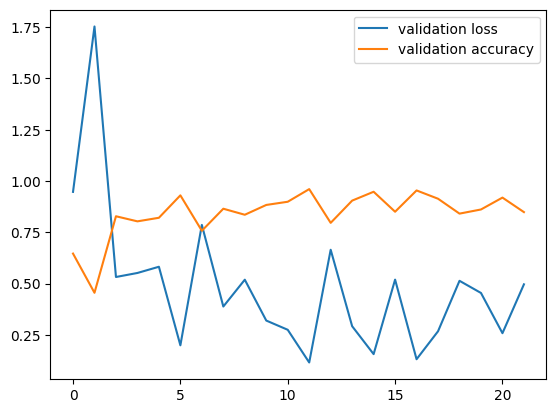

In [ ]:
plt.plot(history.history['val_loss'],label='validation loss')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.legend()

In [ ]:
vgg16_accuracy = history.history['val_accuracy'][len(history.history['val_accuracy'])-1]

AlexNet


In [ ]:
alexnet=Sequential([
                Conv2D(96,11,activation='relu',strides=4,input_shape=(Size,Size,3)),
                BatchNormalization(),
                MaxPooling2D(3,strides=2),


                Conv2D(256,5,activation='relu',strides=1),
                MaxPooling2D(3,strides=2),

                Conv2D(384,3,activation='relu',strides=1),
                Conv2D(384,3,activation='relu',strides=1),
                Conv2D(256,3,activation='relu',strides=1),
                MaxPooling2D(3,strides=2),
                Flatten(),
                Dense(4096,activation='relu'),
                Dense(4096,activation='relu'),
                Dense(38,activation='softmax')
])

In [ ]:
alexnet.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history=alexnet.fit(train_generator,validation_data=valid_generator,epochs=100,batch_size=32,
                  steps_per_epoch=len(train_generator)//16,validation_steps=len(valid_generator)//16,
                  callbacks=callback, verbose=1)

Epoch 1/100
274/274 [==============================] - ETA: 0s - loss: 3.5999 - accuracy: 0.0431
Epoch 1: val_loss did not improve from 0.11509
274/274 [==============================] - 61s 204ms/step - loss: 3.5999 - accuracy: 0.0431 - val_loss: 3.6622 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/100
274/274 [==============================] - ETA: 0s - loss: 3.4572 - accuracy: 0.0525
Epoch 2: val_loss did not improve from 0.11509
274/274 [==============================] - 58s 212ms/step - loss: 3.4572 - accuracy: 0.0525 - val_loss: 3.5331 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/100
274/274 [==============================] - ETA: 0s - loss: 3.2700 - accuracy: 0.0894
Epoch 3: val_loss did not improve from 0.11509
274/274 [==============================] - 71s 258ms/step - loss: 3.2700 - accuracy: 0.0894 - val_loss: 3.4140 - val_accuracy: 0.0018 - lr: 0.0010
Epoch 4/100
274/274 [==============================] - ETA: 0s - loss: 3.1047 - accuracy: 0.1188
Epoch 4: val_loss did 

In [ ]:
ModelLoss, ModelAccuracy = alexnet.evaluate(valid_generator)
print('Test Loss is {}'.format(ModelLoss))
print('Test Accuracy is {}'.format(ModelAccuracy ))

1099/1099 [==============================] - 30s 27ms/step - loss: 1.2546 - accuracy: 0.5983
Test Loss is 1.2545597553253174
Test Accuracy is 0.5982813835144043


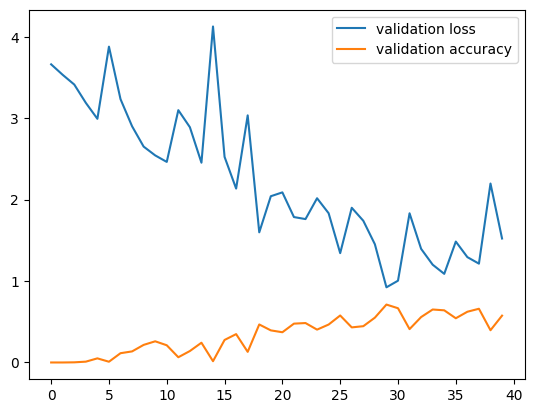

In [ ]:
plt.plot(history.history['val_loss'],label='validation loss')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.legend()

In [ ]:
alexnet_accuracy = history.history['val_accuracy'][len(history.history['val_accuracy'])-1]

Model selection

In [ ]:
models = ["alexnet","vgg16","inceptionv3"]
Models = [alexnet,VGG16,inception3]

accuracies = [alexnet_accuracy,vgg16_accuracy,inceptionv3_accuracy]

best_model_index = accuracies.index(max(accuracies))
print("best performing model :",models[best_model_index])
best_model_name = models[best_model_index]
best_model = Models[best_model_index]

best performing model : inceptionv3


metrics applied on best model

In [ ]:
predictions=best_model.predict(valid_generator)

1099/1099 [==============================] - 44s 39ms/step


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(valid_generator.classes, predictions.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95       504
           1       0.97      0.98      0.98       497
           2       0.93      0.96      0.94       440
           3       0.98      0.85      0.91       502
           4       0.97      0.93      0.95       454
           5       1.00      0.86      0.92       421
           6       0.98      0.97      0.98       456
           7       0.88      0.94      0.91       410
           8       0.99      0.99      0.99       477
           9       0.95      0.86      0.91       477
          10       1.00      1.00      1.00       465
          11       0.95      0.96      0.95       472
          12       0.96      0.96      0.96       480
          13       1.00      0.98      0.99       430
          14       1.00      0.98      0.99       423
          15       0.93      1.00      0.96       503
          16       0.96      0.97      0.96       459
          17       0.99    

<Axes: >

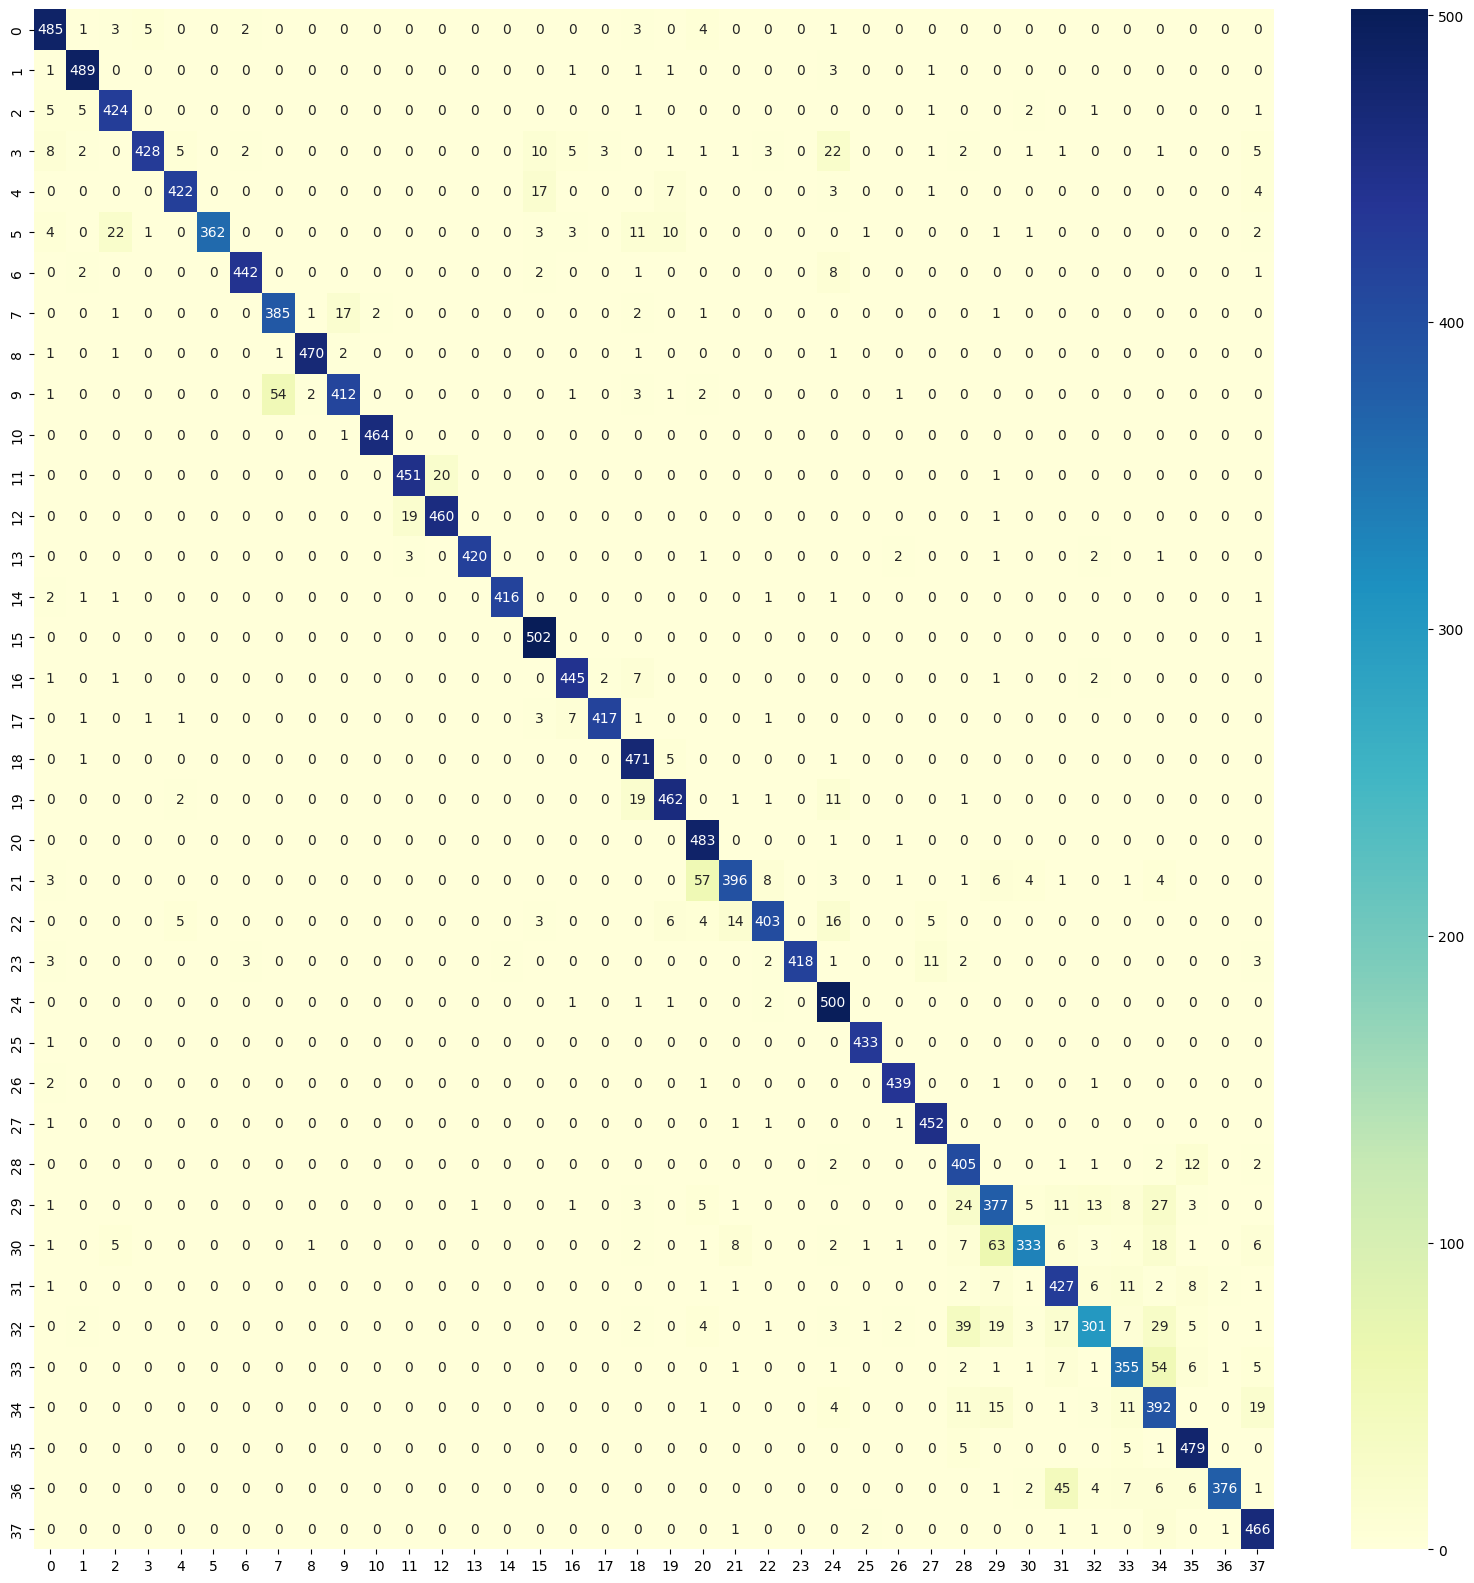

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(valid_generator.classes, predictions.argmax(axis=1))
plt.figure(figsize=(20,20))
sns.heatmap(cm,  annot=True, fmt="d" ,cmap="YlGnBu")

Inference on new examples

In [ ]:
y_pred=best_model.predict(X_test)

35/35 [==============================] - 7s 100ms/step


In [ ]:
y_pred[0]

array([2.95698470e-07, 9.94997661e-12, 5.44314482e-10, 2.36617087e-10,
       4.94949741e-12, 4.71316319e-11, 1.01809620e-11, 6.66750655e-09,
       1.18279761e-11, 2.49989220e-08, 3.57607628e-12, 2.99551725e-13,
       8.89254761e-13, 1.08324205e-09, 4.28227558e-11, 9.72918144e-13,
       1.57313225e-12, 6.53376984e-13, 4.97633472e-08, 1.66665085e-11,
       7.87625968e-01, 2.12319076e-01, 7.42096336e-06, 1.00211617e-09,
       2.01628637e-07, 1.90962329e-10, 1.02114764e-05, 8.08318319e-08,
       9.38455891e-09, 2.95701266e-05, 2.81012660e-07, 6.08400796e-07,
       5.23891686e-06, 1.25394024e-08, 5.12849908e-07, 1.15016566e-10,
       2.91135033e-10, 3.41679907e-07], dtype=float32)

In [ ]:
predictions=y_pred.argmax(axis=1)

In [ ]:
classes

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_

In [ ]:
predictions

array([20,  2,  2, ..., 35, 35,  0])

In [ ]:
predictions[0]

20

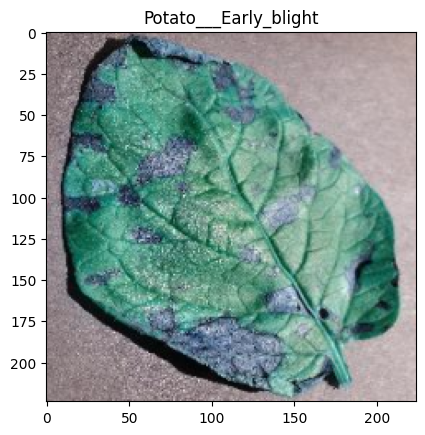

In [ ]:
plt.imshow(X_test[0])
plt.title(classes[predictions[0]])
plt.show()

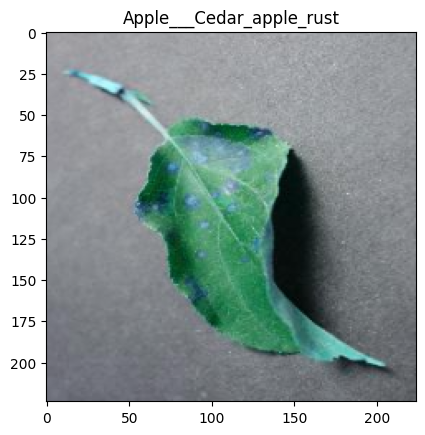

In [ ]:
plt.imshow(X_test[1])
plt.title(classes[predictions[1]])
plt.show()

In [ ]:
plt.imshow(X_test[11])
plt.title(classes[predictions[11]])
plt.show()

NameError: name 'plt' is not defined

CONCLUSION
InceptionV3 model emerged as the best performing model among the considered architectures, including AlexNet and VGG16. The classification report reveals high precision, recall, and F1-score across multiple classes, indicating robust performance in predicting plant diseases.

Specifically, the precision, recall, and F1-score metrics for each class demonstrate consistently high values, with some classes achieving near-perfect scores. This suggests that the InceptionV3 model effectively distinguishes between different types of plant diseases, making accurate predictions across a wide range of classes.

The overall accuracy of the InceptionV3 model on the validation set is reported to be 93%, further underscoring its effectiveness in plant disease prediction.

In conclusion, based on the comprehensive evaluation metrics and the achieved accuracy, the InceptionV3 model is deemed highly suitable for the task of plant disease prediction and can serve as a reliable tool for agricultural applications.